In [1]:
from fashion_clip.fashion_clip import FashionCLIP
from PIL import Image
import json
import os
from tqdm import tqdm
import pickle
import torch
torch.backends.cudnn.benchmark = True
from concurrent.futures import ThreadPoolExecutor
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from data_pipeline import *
import torch.nn.functional as F
import numpy as np
from transformers import pipeline
import sklearn
from sklearn.neighbors import NearestNeighbors
from accelerate import Accelerator
from openai import OpenAI

/home/anyxling/lxl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preprocessing

In [2]:
with open("polyvore/train_no_dup.json", "r") as f:
    train = json.load(f)

with open("polyvore/valid_no_dup.json", "r") as f:
    val = json.load(f)

with open("polyvore/test_no_dup.json", "r") as f:
    test = json.load(f)

In [ ]:
# valid_items_train = get_valid_items(train)

In [ ]:
# with open("valid_items_train.json", "w") as f:
    # json.dump(valid_items_train, f)

In [ ]:
# valid_items_val = get_valid_items(val)
# with open("valid_items_val.json", "w") as f:
#     json.dump(valid_items_val, f)

In [ ]:
# item_ids_train, img_embed_train, text_embed_train = create_embeds(valid_items_train)
# item_ids_val, img_embed_val, text_embed_val = create_embeds(valid_items_val)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|██████████| 9/9 [05:39<00:00, 37.76s/it]


In [ ]:
# with open("item_ids_val.json", "w") as f:
#     json.dump(item_ids_val, f)
# torch.save(img_embed_val, "fashionclip_polyvore_image_embeddings_val.pt")
# torch.save(text_embed_val, "fashionclip_polyvore_text_embeddings_val.pt")

In [3]:
with open("item_ids_train.json", "r") as f:
    item_ids_train = json.load(f)
img_embed_train = torch.load("image_embeddings_train.pt") 
text_embed_train = torch.load("text_embeddings_train.pt") 

with open("item_ids_val.json", "r") as f:
    item_ids_val = json.load(f)
img_embed_val = torch.load("image_embeddings_val.pt") 
text_embed_val = torch.load("text_embeddings_val.pt") 

with open("valid_items_train.json", "r") as f:
    valid_items_train = json.load(f)
with open("valid_items_val.json", "r") as f:
    valid_items_val = json.load(f)

In [4]:
map_img_train = map_id_embed(item_ids_train, img_embed_train)
map_text_train = map_id_embed(item_ids_train, text_embed_train)

map_img_val = map_id_embed(item_ids_val, img_embed_val)
map_text_val = map_id_embed(item_ids_val, text_embed_val)

In [ ]:
# compatibility_data_train = create_compatibility_data(train, item_ids_train)
# compatibility_data_val = create_compatibility_data(val, item_ids_val)

### Train base model for compatibility score prediction

In [17]:
class OutfitDataset(Dataset):
    def __init__(self, outfits, emb_map):
        self.samples = []
        self.labels = []
        self.emb_map = emb_map

        for outfit in outfits:
            self.labels.append(outfit[0])
            self.samples.append(outfit[1:])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        indices = self.samples[idx]
        embeds = torch.stack([self.emb_map[i] for i in indices])  # (num_items, embed_dim)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return embeds, label
        
# pad different seq len
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs_padded = pad_sequence(xs, batch_first=True)  # shape: (batch, max_len, embed_dim)
    ys = torch.stack(ys)
    return xs_padded, ys

In [5]:
# Transformer-Based Scorer
class TransformerScorer(nn.Module):
    def __init__(self, embed_dim, nhead=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pooling = nn.AdaptiveAvgPool1d(1)  # aggregate item representations
        self.scorer = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.transformer(x)                  # (batch, num_items, embed_dim)
        x = x.mean(dim=1)                        # (batch, embed_dim)
        return self.scorer(x).squeeze()          # (batch,)

In [ ]:
def evaluate(model, val_loader, criterion):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss = criterion(logits, y)
            total_val_loss += loss.item()
    model.train()  # switch back to train mode
    return total_val_loss

In [20]:
def train(model, train_loader, val_loader, max_epochs=100, patience=5):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        total_train_loss = 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Evaluate on validation set
        val_loss = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}: Train Loss = {total_train_loss:.4f} | Val Loss = {val_loss:.4f}")

        # Early stopping on val loss
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"checkpoints/epoch{epoch+1}.pt")
            print("Saved best model")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs (no val improvement for {patience} epochs)")
            break

In [ ]:
train_ds = OutfitDataset(compatibility_data_train, map_img_train)
val_ds = OutfitDataset(compatibility_data_val, map_img_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

model = TransformerScorer(img_embed_train.size(1)).cuda()

train(model, train_loader, val_loader)

Epoch 1: 100%|██████████| 1083/1083 [00:11<00:00, 91.78it/s] 


Epoch 1: Train Loss = 481.0630 | Val Loss = 33.3582
Saved best model


Epoch 2: 100%|██████████| 1083/1083 [00:10<00:00, 103.66it/s]


Epoch 2: Train Loss = 284.4739 | Val Loss = 25.0133
Saved best model


Epoch 3: 100%|██████████| 1083/1083 [00:09<00:00, 112.09it/s]


Epoch 3: Train Loss = 207.8269 | Val Loss = 24.3419
Saved best model


Epoch 4: 100%|██████████| 1083/1083 [00:10<00:00, 105.27it/s]


Epoch 4: Train Loss = 157.4768 | Val Loss = 25.8591


Epoch 5: 100%|██████████| 1083/1083 [00:10<00:00, 103.76it/s]


Epoch 5: Train Loss = 113.9442 | Val Loss = 29.5797


Epoch 6: 100%|██████████| 1083/1083 [00:09<00:00, 115.70it/s]


Epoch 6: Train Loss = 81.5527 | Val Loss = 33.3362


Epoch 7: 100%|██████████| 1083/1083 [00:10<00:00, 105.86it/s]


Epoch 7: Train Loss = 61.1695 | Val Loss = 34.6146


Epoch 8: 100%|██████████| 1083/1083 [00:10<00:00, 106.66it/s]


Epoch 8: Train Loss = 55.1808 | Val Loss = 33.2049
Early stopping after 8 epochs (no val improvement for 5 epochs)


---

### Fine tune model for FITB 

Data preparation

In [4]:
# build dict for each category
with open('polyvore/category_id.txt', 'r') as file:
    category_id = file.readlines()

In [5]:
category_map = {}
for cat in category_id:
    cat = cat.strip()
    num, text = cat.split(" ", 1)
    category_map[int(num)] = {"description": text}, {"train": []}, {"val": []}, {"test": []}

In [ ]:
category_map = map_category_items(train, "train", category_map, item_ids_train)
category_map = map_category_items(val, "val", category_map, item_ids_val)

In [11]:
len(category_map)

380

In [ ]:
fill_in_blank_train = create_fitb_data(train, "train", category_map)
fill_in_blank_val = create_fitb_data(val, "val", category_map)

In [ ]:
# with open("fill_in_blank_val.json", "w") as f:
#     json.dump(fill_in_blank_val, f)

Start training

In [15]:
def triplet_loss(pos_score, neg_score, margin=0.2):
    return F.relu(margin - (pos_score - neg_score)).mean()

In [18]:
def evaluate_fitb_accuracy(model, val_data, emb_dict_val):
    model.eval()
    correct, total = 0, 0

    for sample in val_data:
        context = sample["question"]
        blank_pos = sample["blank_position"]
        candidates = sample["answers"]

        scores = []
        for c in candidates:
            filled = context.copy()
            filled.insert(blank_pos, c)
            if not all(x in emb_dict_val for x in filled):
                continue
            x = torch.stack([emb_dict_val[i] for i in filled]).unsqueeze(0).cuda()
            with torch.no_grad():
                score = model(x)
            scores.append(score.item())

        if not scores:
            continue

        pred_idx = torch.tensor(scores).argmax().item()
        if pred_idx == 0:
            correct += 1
        total += 1

    return correct / total if total > 0 else 0.0

In [29]:
def train_triplet_epochs_with_eval(
    model, train_data, val_data, emb_dict_train, emb_dict_val,
    optimizer, epochs=10, patience=5, alpha=1.0
):
    model = model.cuda()
    best_acc = 0
    no_improve = 0
    ce_loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        triplet_count = 0

        for sample in train_data:
            context = sample["question"]
            blank_pos = sample["blank_position"]
            candidates = sample["answers"]  # 1 correct + 3 incorrect

            if len(candidates) != 4:
                continue

            # -------- Triplet Loss --------
            pos = candidates[0]
            negs = candidates[1:]

            pos_ctx = context.copy()
            pos_ctx.insert(blank_pos, pos)
            if not all(x in emb_dict_train for x in pos_ctx):
                continue
            pos_emb = torch.stack([emb_dict_train[x] for x in pos_ctx]).unsqueeze(0).cuda()

            for neg in negs:
                neg_ctx = context.copy()
                neg_ctx.insert(blank_pos, neg)
                if not all(x in emb_dict_train for x in neg_ctx):
                    continue
                neg_emb = torch.stack([emb_dict_train[x] for x in neg_ctx]).unsqueeze(0).cuda()

                # Recompute pos_score for each triplet
                pos_score = model(pos_emb)
                neg_score = model(neg_emb)
                loss_triplet = F.relu(0.2 - (pos_score - neg_score))

                # -------- Cross-Entropy Loss --------
                filled_variants = []
                valid = True
                for c in candidates:
                    temp = context.copy()
                    temp.insert(blank_pos, c)
                    if not all(x in emb_dict_train for x in temp):
                        valid = False
                        break
                    embeds = torch.stack([emb_dict_train[x] for x in temp])
                    filled_variants.append(embeds)
                if not valid:
                    continue

                batch_x = torch.stack(filled_variants).cuda()  # shape: (4, seq_len, dim)
                scores = model(batch_x)  # shape: (4,)
                label = torch.tensor([0], dtype=torch.long).cuda()  # correct = index 0
                loss_ce = ce_loss_fn(scores.unsqueeze(0), label)

                # -------- Combine losses --------
                loss = loss_triplet + alpha * loss_ce

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                triplet_count += 1

        avg_loss = total_loss / triplet_count if triplet_count else 0.0
        val_acc = evaluate_fitb_accuracy(model, val_data, emb_dict_val)

        print(f"Epoch {epoch+1}: Hybrid Loss = {avg_loss:.4f} | Val FITB Acc = {val_acc:.4f}")

        if val_acc > best_acc + 1e-4:
            best_acc = val_acc
            no_improve = 0
            torch.save(model.state_dict(), f"checkpoints_fitb/epoch{epoch+1}.pt")
            print("Saved best model")
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping — no val improvement")
            break

In [30]:
model = TransformerScorer(embed_dim=512)  
model.load_state_dict(torch.load("checkpoints_cs/epoch3.pt"))
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_triplet_epochs_with_eval(
    model=model,
    train_data=fill_in_blank_train,
    val_data=fill_in_blank_val,
    emb_dict_train=map_img_train,
    emb_dict_val=map_img_val,
    optimizer=optimizer,
    epochs=10,
    patience=5
)

Epoch 1: Hybrid Loss = 1.5192 | Val FITB Acc = 0.4276
Saved best model
Epoch 2: Hybrid Loss = 1.4439 | Val FITB Acc = 0.4462
Saved best model
Epoch 3: Hybrid Loss = 1.4035 | Val FITB Acc = 0.4313
Epoch 4: Hybrid Loss = 1.3724 | Val FITB Acc = 0.4491
Saved best model
Epoch 5: Hybrid Loss = 1.3472 | Val FITB Acc = 0.4506
Saved best model
Epoch 6: Hybrid Loss = 1.3238 | Val FITB Acc = 0.4402
Epoch 7: Hybrid Loss = 1.3059 | Val FITB Acc = 0.4417
Epoch 8: Hybrid Loss = 1.3060 | Val FITB Acc = 0.4187
Epoch 9: Hybrid Loss = 1.3078 | Val FITB Acc = 0.4447
Epoch 10: Hybrid Loss = 1.3080 | Val FITB Acc = 0.4306
Early stopping — no val improvement


---
### Outfit generation

In [6]:
model = TransformerScorer(embed_dim=512)  
model.load_state_dict(torch.load("checkpoints_fitb/epoch5.pt"))
model = model.cuda()

In [14]:
# Initialize OpenRouter client
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="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",
)

# Ask user for input
occasion = input("What occasion do you need this outfit for?")
sex = input("what's your gender")

# Build dynamic prompt
prompt = f"""You're a fashion stylist. A {sex} user is going to the following occasion: {occasion}.
Suggest exactly 4 individual fashion items they should wear.
Do not include beauty products. Do not offer alternatives like “or”.
List only fashion/clothing/accessory items, separate them with comma, do not show them in lines."""

# Call OpenRouter model
completion = client.chat.completions.create(
    model="meta-llama/llama-3.1-8b-instruct:free",
    extra_headers={
        "HTTP-Referer": "https://yourproject.example",  # optional
        "X-Title": "FashionRAG",  # optional
    },
    messages=[
        {"role": "user", "content": prompt}
    ]
)

print(completion.choices[0].message.content)

Flowy sundress, pair of sandals, wide-brimmed straw hat, layered shell necklace


In [29]:
# Step 2: Encode each item description to FashionCLIP text embedding
fclip = FashionCLIP("fashion-clip")  # already on CUDA
fclip.device = "cuda"

response = completion.choices[0].message.content
item_texts = [item.strip() for item in response.split(',')]

def encode_query_items(item_texts):
    return fclip.encode_text(item_texts, batch_size=len(item_texts))

item_text_embeds = encode_query_items(item_texts)

100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


In [45]:
item_text_embeds

array([[ 0.29194933,  0.43206954, -0.07534778, ...,  0.02398443,
        -0.0205105 ,  0.10099345],
       [-0.11922351, -0.05279587, -0.31061402, ...,  0.18105188,
        -0.3343269 , -0.2219441 ],
       [-0.04727783,  0.22690797, -0.36393398, ...,  0.4998045 ,
        -0.45429233,  0.18179214],
       [ 0.3512357 ,  0.27562356, -0.24466944, ..., -0.23998123,
        -0.09204236, -0.1294156 ]], shape=(4, 512), dtype=float32)

In [40]:
# Step 3: Retrieve real catalog items (nearest neighbor search)
def retrieve_similar_items(text_embs, k=1):
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(text_embeddings.cpu().numpy())
    indices = knn.kneighbors(text_embs.cpu().numpy(), return_distance=False)
    retrieved_ids = [[item_ids[i] for i in row] for row in indices]
    return retrieved_ids

In [ ]:
# Step 4: Score combinations using your compatibility model
def score_outfit(outfit_ids, emb_dict):
    if not all(x in emb_dict for x in outfit_ids):
        return -np.inf
    embeds = torch.stack([emb_dict[x] for x in outfit_ids]).unsqueeze(0).cuda()
    with torch.no_grad():
        score = model(embeds).item()
    return score

In [ ]:
# Step 5: Generate and rerank outfit from prompt
def generate_outfit_from_prompt(prompt, emb_dict, top_k=1):
    concepts = generate_outfit_items(prompt)
    text_embs = encode_query_items(concepts)
    candidate_ids = retrieve_similar_items(torch.tensor(text_embs).cuda(), k=top_k)

    # Generate all combinations (assuming k=1, so one per concept)
    combinations = list(zip(*candidate_ids))  # [(id1, id2, id3, id4)]
    best_combo = max(combinations, key=lambda combo: score_outfit(combo, emb_dict))
    return best_combo, concepts

In [29]:
import requests

API_KEY = "0db13be3f5563366aed5781b81d39c7f"
city = 'San Francisco'
url = f'https://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=imperial'


response = requests.get(url)
data = response.json()

print(f"The current weather in {city} is {data['weather'][0]['main']} with a temperature of {data['main']['temp']}°F, ranging from a low of {data['main']['temp_min']}°F to a high of {data['main']['temp_max']}°F.")

The current weather in San Francisco is Clouds with a temperature of 51.28°F, ranging from a low of 48.24°F to a high of 53.83°F.


In [12]:
og = OutfitGenerator(text_embed_train, map_img_train, item_ids_train, model)
og.start_generate()

100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


"We recommend you these items: ['Soft', 'lightweight scarf', 'white tank top', 'high-waisted jeans', 'pair of slip-on sneakers'], the corresponding ids are: [['200235151_4'], ['180793421_6'], ['155197895_1'], ['119628790_3'], ['186768559_3']]. This whole outfit has a score of 0.19258810579776764."

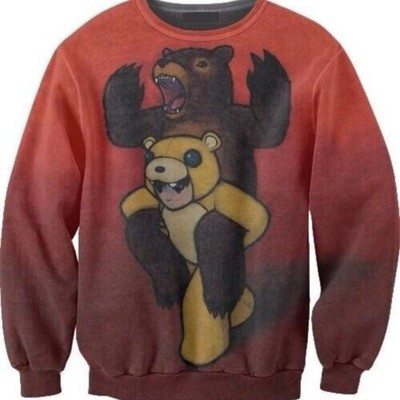

In [13]:
Image.open('polyvore/images/200235151/4.jpg')

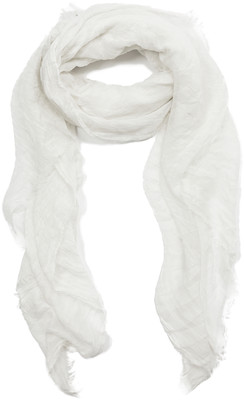

In [14]:
Image.open('polyvore/images/180793421/6.jpg')

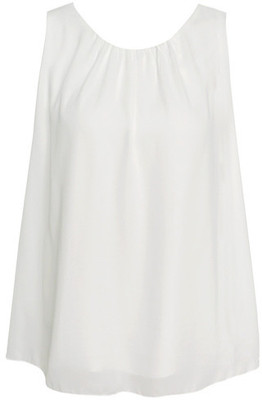

In [17]:
Image.open('polyvore/images/155197895/1.jpg')

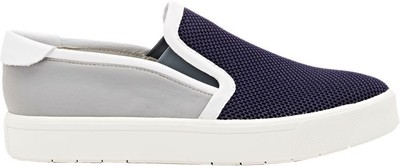

In [18]:
Image.open('polyvore/images/186768559/3.jpg')

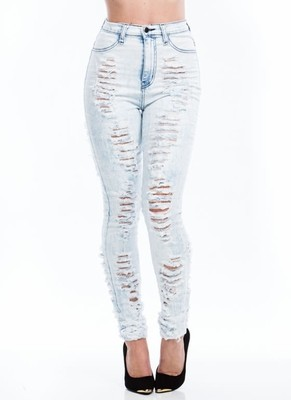

In [19]:
Image.open('polyvore/images/119628790/3.jpg')